In [77]:
# default_exp losses

# Losses

> Custom loss functions.

In [78]:
#hide
from nbdev.showdoc import *

In [79]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
# export
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F

from htools import add_docstring, valuecheck, identity
from incendio.layers import SmoothLogSoftmax

In [6]:
# Used for testing only.
from fastai2.metrics import LabelSmoothingCrossEntropy
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

from htools import assert_raises, InvalidArgumentError

/Users/hmamin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/hmamin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [ ]:
# export
def smooth_soft_labels(labels, alpha=.1):
    """Add uniform probability to a tensor of soft labels or 
    one-hot-encoded hard labels. Classes with zero probability
    will therefore end up with alpha/k probability, where k is
    the total number of classes. Note that some implementations
    may use alpha/(k-1), so if you notice a difference in output 
    that could be the source.
    
    Parameters
    ----------
    labels: torch.tensor
        Tensor of labels where each row is a sample and each column
        is a class. These can be one hot encodings or a vector of soft
        probabilities. Shape (batch_size, num_classes).
    alpha: float
        A positive value which will be used to assign nonzero 
        probabilities to the classes that are currently zeros. A larger
        alpha corresponds to a higher degree of smoothing (useful when
        accounting for noisier labels, trying to provide a stronger
        regularizing effect, or encouraging less confident predictions).
    """
    if alpha < 0:
        raise InvalidArgumentError('Alpha must be non-negative.')
    
    # Avoid unnecessary computation.
    if not alpha: 
        return labels
    length = labels.shape[-1]
    nonzeros = (labels > 0).sum(-1).unsqueeze(-1).float()
    return torch.clamp_min(labels - alpha/nonzeros, 0) + alpha/length

In [ ]:
# export
def soft_label_cross_entropy_with_logits(y_pred, y_true, alpha=0.0, 
                                         reduction='mean'):
    """Compute cross entropy with soft labels. PyTorch's built in 
    multiclass cross entropy functions require us to pass in integer
    indices, which doesn't allow for soft labels which are shaped like
    a one hot encoding. FastAI's label smoothing loss uniformly divides
    uncertainty over all classes, which again does not allow us to pass
    in our own soft labels.
    
    Parameters
    ----------
    y_pred: torch.FloatTensor
        Logits output by the model. 
        Shape (bs, num_classes).
    y_true: torch.FloatTensor
        Soft labels, where values are between 0 and 1. 
        Shape (bs, num_classes).
    alpha: float
        Label smoothing hyperparameter: a positive value which will be used to
        assign nonzero probabilities to the classes that are currently zeros. 
        A larger alpha corresponds to a higher degree of smoothing (useful when
        accounting for noisier labels, trying to provide a stronger
        regularizing effect, or encouraging less confident predictions).
    reduction: str
        One of ('mean', 'sum', 'none'). This determines how to reduce
        the output of the function, similar to most PyTorch
        loss functions.

    Returns
    -------
    torch.FloatTensor: If reduction is 'none', this will have shape
        (bs, ). If 'mean' or 'sum', this will be be a tensor with a 
        single value (no shape).
    """
    res = (-smooth_soft_labels(y_true, alpha) 
           * F.log_softmax(y_pred, dim=-1)).sum(-1)
    if reduction == 'none': return res
    return getattr(res, reduction)(0)

In [ ]:
# export
@add_docstring(soft_label_cross_entropy_with_logits)
def soft_label_cross_entropy(y_pred, y_true, alpha=0.0, reduction='mean'):
    """Same as `soft_label_cross_entropy_with_logits` but operates on
    softmax output instead of logits. The version with logits is 
    recommended for numerical stability. Below is the docstring for the logits 
    version. The only difference in this version is that y_pred will not be
    logits.
    """
    res = -smooth_soft_labels(y_true, alpha) * torch.log(y_pred)
    res = torch.where(torch.isnan(res) | torch.isinf(res),
                      torch.zeros_like(res), res).sum(-1)
    if reduction == 'none': return res
    return getattr(res, reduction)(0)

For demonstration, each row of our soft labels tries to capture a different case: 
- Row 0: High confidence label for one class, model has high confidence in the correct class.
- Row 1: Moderate confidence in 2 different classes, model has high confidence in the best class.
- Row 2: Confidence is split between a few classes, model predictions assign most probability to the two nonzero but non-ideal classes.

Row 2 should benefit slightly from label smoothing since it predicts answers that are not ideal but not entirely wrong.

In [ ]:
# 3 row mini batch
y_label = torch.tensor([0, 1, 3])
y_ohe = torch.tensor([[1, 0, 0, 0, 0],
                      [0, 1, 0, 0, 0], 
                      [0, 0, 0, 1, 0]], dtype=torch.float)
y_smooth = torch.tensor([[.9, .1, 0, 0, 0],
                         [.35, .65, 0, 0, 0],
                         [0, .1, .2, .7, 0]])
logits = torch.tensor([[6, 1, 3, 1, 2], 
                       [5, 8, 1, 1, 2],
                       [1, 3, 4, 2, 0]], dtype=torch.float)
y_hat = F.softmax(logits, dim=-1)
y_hat

tensor([[9.2457e-01, 6.2297e-03, 4.6032e-02, 6.2297e-03, 1.6934e-02],
        [4.7232e-02, 9.4869e-01, 8.6509e-04, 8.6509e-04, 2.3516e-03],
        [3.1685e-02, 2.3412e-01, 6.3641e-01, 8.6129e-02, 1.1656e-02]])

In [ ]:
# Test: smooth_soft_labels
assert torch.allclose(
    smooth_soft_labels(y_smooth, .1), 
    torch.tensor([[0.8700, 0.0700, 0.0200, 0.0200, 0.0200],
                  [0.3200, 0.6200, 0.0200, 0.0200, 0.0200],
                  [0.0200, 0.0867, 0.1867, 0.6867, 0.0200]]),
atol=1e-3), 'Case 1: alpha=0.1'

assert torch.allclose(smooth_soft_labels(y_smooth, 0.0), y_smooth, atol=1e-3),\
    'Case 2: alpha=0.0'

with assert_raises(InvalidArgumentError):
    smooth_soft_labels(y_smooth, -.1)

As expected, got InvalidArgumentError(Alpha must be non-negative.).


In [ ]:
modes = ('none', 'sum', 'mean')
for mode in modes:
    j = soft_label_cross_entropy_with_logits(logits, y_ohe, reduction=mode)
    print(f'reduction={mode}:', j)

reduction=none: tensor([0.0784, 0.0527, 2.4519])
reduction=sum: tensor(2.5830)
reduction=mean: tensor(0.8610)


In [ ]:
print('soft_label_cross_entropy_with_logits:\n' + '-'*37)
for mode in modes:
    j = soft_label_cross_entropy_with_logits(logits, y_smooth, reduction=mode)
    print(f'reduction={mode}:', j)

print('\nsoft_label_cross_entropy:\n' + '-'*25)
for mode in modes:
    j = soft_label_cross_entropy(y_hat, y_smooth, reduction=mode)
    print(f'reduction={mode}:', j)

soft_label_cross_entropy_with_logits:
-------------------------------------
reduction=none: tensor([0.5784, 1.1027, 1.9519])
reduction=sum: tensor(3.6330)
reduction=mean: tensor(1.2110)

soft_label_cross_entropy:
-------------------------
reduction=none: tensor([0.5784, 1.1027, 1.9519])
reduction=sum: tensor(3.6330)
reduction=mean: tensor(1.2110)


In [ ]:
for mode in modes:
    j = soft_label_cross_entropy_with_logits(logits, y_smooth, alpha=.2, 
                                             reduction=mode)
    print(f'reduction={mode}:', j)

reduction=none: tensor([0.7584, 1.7227, 2.1519])
reduction=sum: tensor(4.6330)
reduction=mean: tensor(1.5443)


In [ ]:
def plot_loss_by_alpha(y_pred, y_true, loss_func=None, loss_class=None):
    alphas = np.arange(0, 1, .05)
    
    if loss_class:
        js = {a: loss_class(a, 'none')(y_pred, y_true) for a in alphas}
    else:
        js = {a: loss_func(y_pred, y_true, a, 'none') for a in alphas}

    fig, ax = plt.subplots()
    for i in range(3):
        ax.plot(alphas, [x[i] for x in js.values()], label=i)
    plt.xlabel('Alpha (Smoothing Parameter)')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Notice the gap between row 2 begins to narrow, as predicted.

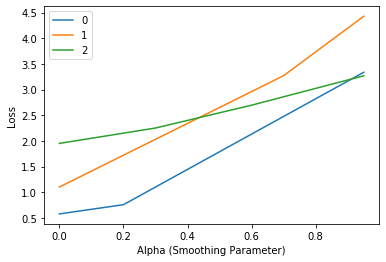

In [ ]:
plot_loss_by_alpha(y_hat, y_smooth, soft_label_cross_entropy)

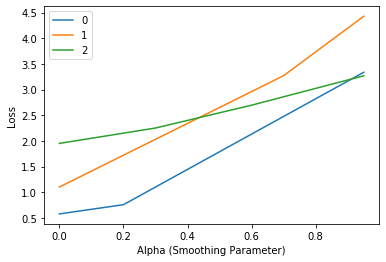

In [ ]:
plot_loss_by_alpha(logits, y_smooth, soft_label_cross_entropy_with_logits)

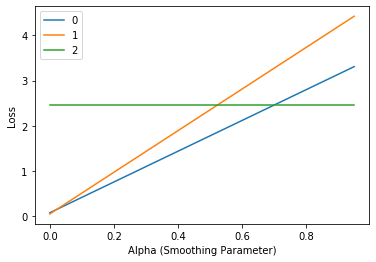

In [ ]:
plot_loss_by_alpha(logits, y_ohe, soft_label_cross_entropy_with_logits)

For comparison, here is the fastai label smoothing loss. It should return the same results in this case (just adding uniform noise). The advantage of ours is the ability to specify a prior non-uniform distribution.

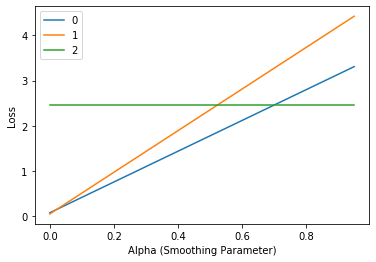

In [ ]:
plot_loss_by_alpha(logits, y_label, loss_class=LabelSmoothingCrossEntropy)

In [ ]:
def classification_mae_with_logits(y_pred, y_true, reduction='mean'):
    """Mean absolute error for classification using soft or one hot encoded
    labels (can be helpful for dealing with noisy labels). Classification
    models often forego the final softmax layer and use a loss function which
    computes the log softmax for numerical stability reasons. This loss 
    function makes it easy to swap different loss functions in and out without
    changing the model or the training loop.
    
    Parameters
    ----------
    y_pred: torch.FloatTensor
        Logits. Shape (bs, num_classes).
    y_true: torch.FloatTensor
        Labels, either one hot encoded or soft. Shape (bs, num_classes).
    reduction: str
        Just like any PyTorch loss function, this determines how to aggregate
        the loss over a mini batch. One of ('mean', 'sum', 'none').
    """
    # Built-in reduction will aggregate over every value in the tensor because
    # it expects that we're predicting a single value per sample. Because 
    # we're predicting a vector for each sample, we compute row-wise sums 
    # regardless of our choice of reduction, then aggregate over the batch 
    # dimension if specified.
    rowwise_j = F.l1_loss(F.softmax(y_pred, dim=-1),
                          y_true, reduction='none').sum(-1)
    if reduction == 'none': return rowwise_j
    return getattr(rowwise_j, reduction)(dim=-1)

In [ ]:
logits

tensor([[6., 1., 3., 1., 2.],
        [5., 8., 1., 1., 2.],
        [1., 3., 4., 2., 0.]])

In [ ]:
F.softmax(logits, dim=-1)

tensor([[9.2457e-01, 6.2297e-03, 4.6032e-02, 6.2297e-03, 1.6934e-02],
        [4.7232e-02, 9.4869e-01, 8.6509e-04, 8.6509e-04, 2.3516e-03],
        [3.1685e-02, 2.3412e-01, 6.3641e-01, 8.6129e-02, 1.1656e-02]])

In [ ]:
y_ohe

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.]])

In [ ]:
for mode in modes:
    j = classification_mae_with_logits(logits, y_ohe, mode)
    print(mode, j) 

none tensor([0.1509, 0.1026, 1.8277])
sum tensor(2.0812)
mean tensor(0.6937)


In [8]:
# export
class PairwiseLossReduction(nn.Module):
    """Basically lets us use L2 or L1 distance as a loss function with the
    standard reductions. If we don't want to reduce, we could use the built-in
    torch function, but that will usually output a tensor rather than a 
    scalar.
    """

    @valuecheck
    def __init__(self, reduce:('sum', 'mean', 'none')='mean', **kwargs):
        super().__init__()
        self.distance = nn.PairwiseDistance(**kwargs)
        self.reduce = identity if reduce == 'none' else getattr(torch, reduce)

    def forward(self, y_proba, y_true):
        return self.reduce(self.distance(y_proba, y_true))

In [82]:
# export
def reduce(x, reduction='mean'):
    """This is a very common line in my custom loss functions so I'm providing
    a convenience function for it. I think this function call is also more 
    intuitive than the code behind it.
    
    Parameters
    ----------
    x: torch.Tensor
        The object to reduce.
    reduction: str
        Should be one of ('mean', 'sum', 'none'), though technically some 
        other operations (e.g. 'std') are supported.
    
    Returns
    -------
    torch.Tensor: Scalar if using 'mean' or 'sum', otherwise the same as 
    input `x`.
    
    Examples
    --------
    def squared_error(x, reduction='mean'):
        return reduce(x.pow(2), reduction)
    """
    return x if reduction == 'none' else getattr(torch, reduction)(x)

In [119]:
# export
def contrastive_loss(x1, x2, y, m=1.25, p=2, reduction='mean'):
    """Functional form of the contrastive loss as described by Hadsell, 
    Chopra, and LeCun in 
    "Dimensionality Reduction by Learning an Invariant Mapping":
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    
    Similar examples always contribute to the loss while negatives only do
    if they are sufficiently similar.
    
    A couple words of caution: this uses the convention that y=1 represents a 
    positive label (similar examples) despite the paper doing the opposite.
    Also, the value of m (margin) might benefit from some tuning as I'm not
    very confident in the default value.
    
    Parameters
    ----------
    x1: torch.Tensor
        Shape (bs, n_features).
    x2: torch.Tensor
        Shape (bs, n_features).
    y: torch.Tensor
        Labels. Unlike the paper, we use the convention that a label of 1 
        means images are similar. This is consistent with all our existing
        datasets and just feels more intuitive.
    m: float
        Margin that prevents dissimilar pairs from affecting the loss unless
        they are sufficiently far apart. I believe the reasonable range of
        values depends on the size of the feature dimension. The default is
        based on a figure in the paper linked above but I'm not sure how
        much stock to put in that.
    p: int
        The p that determines the p-norm used to calculate the initial 
        distance measure between x1 and x2. The default of 2 therefore uses
        euclidean distance.
    reduction: str
        One of ('sum', 'mean', 'none'). Standard pytorch loss reduction. Keep
        in mind 'none' will probably not allow backpropagation since it
        returns a rank 2 tensor.
        
    Returns
    -------
    torch.Tensor: Scalar measuring the contrastive loss. If no reduction is
    applied, this will instead be a tensor of shape (bs,).
    """
    dw = F.pairwise_distance(x1, x2, p, keepdim=True) 
    # Loss_similar + Loss_different
    res = y*dw.pow(p).div(2) + (1-y)*torch.clamp_min(m-dw, 0).pow(p).div(2)
    return reduce(res, reduction)

In [120]:
# export
class ContrastiveLoss1d(nn.Module):
    
    @add_docstring(contrastive_loss)
    def __init__(self, m=1.25, p=2, reduction='mean'):
        """OOP version of contrastive loss. The docs for the functional 
        version are below:
        """
        super().__init__()
        self.m = m
        self.p = p
        self.reduction = reduction
        self.loss = partial(contrastive_loss, m=m, p=p, reduction=reduction)
        
    def forward(self, x1, x2, y_true):
        """
        Parameters
        ----------
        x1: torch.Tensor
            Shape (bs, feature_dim).
        x2: torch.Tensor
            Shape (bs, feature_dim).
        y_true: torch.Tensor
            Shape (bs, 1). 1's indicate the inputs are "similar", 0's indicate
            they are dissimilar.
            
        Returns
        -------
        torch.Tensor: scalar if `reduction` is not 'none', otherwise tensor 
        has same shape as `y_true`.
        """
        assert y_true.ndim == 2, "y_true must be rank 2."
        return self.loss(x1, x2, y_true)

In [112]:
bs = 2
x1 = torch.randn(bs, 5)
x2 = torch.randn(bs, 5)
y = torch.tensor([1, 0]).unsqueeze(-1)

# Make pair 1 similar, pair 2 dissimilar.
x1[0] += torch.arange(0, 100, 20)
x1[1] -= 50
x2[0] += torch.arange(0, 100, 20)
x2[1] += 25

print(x1)
print(x2)

tensor([[ -1.1935,  19.9629,  39.9642,  60.6310,  79.9442],
        [-48.8698, -49.4237, -48.8313, -49.1232, -49.0722]])
tensor([[-0.8069, 18.7798, 38.6250, 59.6368, 80.2849],
        [24.5225, 25.7855, 25.0192, 25.8827, 23.5852]])


In [116]:
loss = ContrastiveLoss1d(reduction='mean')
loss(x1, x2, y)

tensor(1.1118)

In [117]:
loss = ContrastiveLoss1d(reduction='sum')
loss(x1, x2, y)

tensor(2.2235)

In [118]:
loss = ContrastiveLoss1d(reduction='none')
loss(x1, x2, y)

tensor([[2.2235],
        [0.0000]])

In [121]:
# export
class ContrastiveLoss2d(nn.Module):
    
    @add_docstring(contrastive_loss)
    def __init__(self, m=1.25, p=2, reduction='mean'):
        """OOP version of contrastive loss. We're using the name "2d" somewhat
        differently here: we use this module to compare 1 image to n different
        variants. Picture, for instance, a task where a single example 
        contains n+1 images and we want to find which of the final n images 
        are similar to the first image. Concretely, this would be a 
        multi-label (not multi-class) classification problem with OHE labels.
        
        The docs for the functional 
        version are below:
        """
        super().__init__()
        self.m = m
        self.p = p
        self.loss = partial(contrastive_loss, m=m, p=p, reduction='none')
        
        if reduction == 'none':
            self.reduction = identity
        elif reduction == 'row':
            self.reduction = partial(torch.sum, dim=-1)
        else:
            self.reduction = getattr(torch, reduction)
        
    def forward(self, x1, x2, y_true):
        """
        Parameters
        ----------
        x1: torch.Tensor
            Shape (bs, feats).
        x2: torch.Tensor
            Shape (bs, n_item, n_feats).
        y_true:
            Shape (bs, n_item).

        Returns
        ---------
        torch.Tensor: scalar if reduction is 'mean' or 'sum', same shape as y
        """
        # if reduction is 'none', or shape (bs,) if reduction is 'row'.
        bs, n, dim = x2.shape
        res = self.loss(x1.repeat_interleave(n, dim=0), 
                        x2.view(-1, dim),
                        y_true.view(-1, 1))
        return self.reduction(res.view(bs, -1))

In [130]:
x2

tensor([[-0.8069, 18.7798, 38.6250, 59.6368, 80.2849],
        [24.5225, 25.7855, 25.0192, 25.8827, 23.5852]])

In [132]:
# x3 provides 3 examples for each source image in x2. Some are different
# and some are similar (notice where noise is amplified vs. dampened).
noise = torch.rand(bs, 3, 5) * 10
noise[0, [0, -1]] /= 100
noise[0, 1] *= 5
noise[-1, -1] += 500
x3 = x2[:, None, ...] + noise

print(x3.shape)
print(x3)

torch.Size([2, 3, 5])
tensor([[[ -0.7902,  18.7978,  38.6418,  59.6638,  80.3098],
         [ 15.2447,  60.8061,  63.5002,  85.1861,  91.9863],
         [ -0.7529,  18.8695,  38.6729,  59.6541,  80.3533]],

        [[ 31.0942,  31.8574,  28.2461,  35.2123,  28.0060],
         [ 34.3140,  32.5423,  26.9292,  32.1664,  33.0371],
         [531.4734, 534.1118, 531.1953, 532.5379, 529.6300]]])


In [133]:
y2d = torch.tensor([[1, 0, 1],
                    [1, 1, 0]])
y2d

tensor([[1, 0, 1],
        [1, 1, 0]])

In [134]:
loss = ContrastiveLoss2d()
loss(x2, x3, y2d)

tensor(39.2557)

In [135]:
loss = ContrastiveLoss2d(reduction='sum')
loss(x2, x3, y2d)

tensor(235.5344)

In [138]:
loss = ContrastiveLoss2d(reduction='row')
loss(x2, x3, y2d)

tensor([1.0237e-02, 2.3552e+02])

In [141]:
loss = ContrastiveLoss2d(reduction='none')
loss(x2, x3, y2d)

tensor([[1.1175e-03, 0.0000e+00, 9.1191e-03],
        [9.8526e+01, 1.3700e+02, 0.0000e+00]])